# Intro to Encoder-Decoder model and the Attention mechanism

# A neural machine translator from english to spanish short sentences in tf2

We continue our journey through the world of NLP, in this post we are going to describe the **basic architecture of an encoder-decoder model** that we will apply to a neural *machine translation problem*, translating texts from English to Spanish. Later, we will introduce a technique that has been a great step forward in the treatment of NLP tasks: **the attention mechanism**. We will detail a basic processing of the attention applied to a scenario of a *sequence-to-sequence model*, "many to many" approach. But for the moment it will be a simple attention model, we will not comment on more complex models that will be discussed in future posts, when we address the subject of *Transformers*.

### What is Neural Machine Translation?

*Machine translation (MT) is the task of automatically converting source text in one language to text in another language. Given a sequence of text in a source language, there is no one single best translation of that text to another language. This is because of the natural ambiguity and flexibility of human language. This makes the challenge of automatic machine translation difficult, perhaps one of the most difficult in artificial intelligence.*

*Machine Learning Mastery, Jason Brownlee [1]*

The initial approach to MT problems was the statistical machine translation based on the use of statistical models, probabilities, given an input sentence. Neural machine translation, or NMT for short, is the use of neural network models to learn a statistical model for machine translation.
The key benefit to the approach is that a single system can be trained directly on source and target text, no longer requiring the pipeline of specialized systems used in statistical machine learning.

### A basic approach to the Encoder-Decoder model

From the above we can deduce that NMT is a problem where we process an input sequence to produce an output sequence, that is, a sequence-to-sequence (seq2seq) problem. Specifically of the many-to-many type, sequence of several elements both at the input and at the output, and the encoder-decoder architecture for recurrent neural networks is the standard method.

![Alt](images/encoder_decoder_basic.png "title Depiction of Sutskever Encoder-Decoder Model for Text Translation Taken from Sequence to Sequence Learning with Neural Networks, 2014")

The seq2seq model consists of two sub-networks, the encoder and the decoder. The encoder, on the left hand, receives sequences from the source language as inputs and produces as a result a compact representation of the input sequence, trying to summarize or condense all its information. Then that output becomes an input or initial state of the decoder, which can also receive another external input. At each time step, the decoder generates an element of its output sequence based on the input received and its current state, as well as updating its own state for the next time step. 

Mention that the input and output sequences are of fixed size but they do not have to match, the length of the input sequence may differ from that of the output sequence.

The critical point of this model is how to get the encoder to provide the most complete and meaningful representation of its input sequence in a single output element to the decoder. Because this vector or state is the only information the decoder will receive from the input to generate the corresponding output. The longer the input, the harder to compress in a single vector.
We will describe in detail the model and build it in a latter section.

### Importing the libraries and initialize global variables

In [1]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


We set the variables for data location

In [3]:
# Global parameters
#root folder
root_folder='.'
#data_folder='.'
data_folder_name='data'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

The next code cell define the parameters and hyperparameters of our model:

In [4]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'

## The dataset and text processing

For this exercise we will use pairs of simple sentences, the source in English and target in Spanish, from the Tatoeba project where people contribute adding translations every day. This is the [link](http://www.manythings.org/anki/) to some traslations in different languages. There you can download the Spanish - English spa_eng.zip file, it contains 124457 pairs of sentences.

The text sentences are almost clean, they are simple plain text, so we only need to remove accents, lower case the sentences and replace everything with space except (a-z, A-Z, ".", "?", "!", ","). The code to apply this preprocess has been taken from the Tensorflow tutorial for neural machine translation.

### Preprocess the text data


In [5]:
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial
# in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

### Loading the datasets

Load the dataset into a pandas dataframe and apply the preprocess function to the input and target columns.

In [6]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['go .', 'go .', 'go .', 'go .', 'hi .']
['ve . <eos>', 'vete . <eos>', 'vaya . <eos>', 'vayase . <eos>', 'hola . <eos>']
['<sos> ve .', '<sos> vete .', '<sos> vaya .', '<sos> vayase .', '<sos> hola .']


In [7]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

22

## Tokenize and process the text data

Next, let's see how to prepare the data for our model. It is very simple and the steps are the following:
- Tokenize the data, to convert the raw text into a sequence of integers. First, we create a Tokenizer object from the keras library and fit it to our text (one tokenizer for the input and another one for the output).
- Extract sequence of integers from the text: we call the text_to_sequence method of the tokenizer for every input and output text.
- Calculate the maximum length of the input and output sequences.


In [8]:
# Create a tokenizer for the input texts and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[1000])
print(input_sequences[1000])

Max Input Length:  8
are you in ?
[21, 4, 36, 5]


Now we repeat the steps for the output texts but now we do not want to filter special characters otherwise eos and sos token will be removed

In [9]:
# tokenize the outputs
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])
print(target_sequences_inputs[1000])

Max Target Length:  15
¿ estas dentro ? <eos>
[5, 45, 401, 4, 2]
<sos> ¿ estas dentro ?
[3, 5, 45, 401, 4]


## Create the vocabularies

Using the tokenizer we have created previously we can retrieve the vocabularies, one to match word to integer (word2idx) and a second one to match the integer to the corresponding word (idx2word).

In [10]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 3664 unique input tokens.
Found 7168 unique output tokens.


## Padding the sentences

- Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches

In [11]:
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (20000, 8)
encoder_inputs[0]: [31  1  0  0  0  0  0  0]
decoder_inputs[0]: [ 3 99  1  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 15)


### Create the batch data generator

- Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function batch_on_slices on the input and output sequences.

In [12]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

## Build an Encoder-Decoder model with Recurrent Neural Networks

For a better understanding, we can divide the model in three basic components:

![Alt](images/encoder_decoder_RNN.jpeg "From Understanding Encoder-Decoder Sequence to Sequence Model by Simeon Kostadinov [3]")

- The **encoder**: Layers of recurrent units where in each time step, receive a an input token, collects relevant information and produce a hidden state. Depends on the type of RNN, in our example a LSTM, the unit "mixes" the current hidden state and the input and return an output, discarded, and a new hidden state. You can read my post … for more information.


- The **encoder vector**: it is the last hidden state of the encoder and it tries to contain as much of the useful input information as possible to help the decoder get the best results. It is only information from the input that the decoder will get.


- The **decoder**: Layers of recurrent units, i.e. LSTMs, where each unit produces an output at a time step t. The hidden state of the first unit is the encoder vector and the rest of units accept the hidden state from the previous unit. The output is calculated using a softmax function to obtain a  probability for every token in the output vocabulary.

### Encoder class

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

### Decoder class

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state_h, state_c


Once our encoder and decoder are defined we can init them and set the initial hidden state. We have included a simple test, calling the encoder and decoder to check they works fine.

In [40]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
initial_state = encoder.init_states(1)
# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)
# Create the decoder
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
de_initial_state = test_encoder_output[1:]
# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 512)
(1, 8, 11239)


### Create the loss function and metrics

Now we need to define a custom loss function to avoid taking into account the 0 values, padding values, when calculating the loss. And also we have to define a custom accuracy function.

In [14]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total


## Train the model

As we mentioned before, we are interested in training the network in batches, therefore, we create a function that carries out the training of a batch of the data:
- Call the encoder for the batch input sequence, the output is the encoded vector.
- Set the decoder initial states to the encoded vector
- Call the decoder, taking the right shifted target sequence as input. The output are the logits (the softmax function is applied in the loss function)
- Calculate the loss and accuracy of the batch data
- Update the learnable parameters of the encoder and the decoder
- update the optimizer

In [17]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

As you can observe, our train function receives three sequences:

- **Input** sequence: array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the encoder.

- **target** sequence: array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the target of our model, the output that we want for our model.

- **Target input** sequence: array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the decoder because we use *Teacher Forcing*.


### Teacher Forcing

Teacher forcing is a training method critical to the development of deep learning models in NLP. It is a way for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.


In a recurrent network usually the input to a RNN at the time step t is the output of the RNN in the previous time step, t-1. But with teacher forcing we can use the actual output to improve the learning capabilities of the model.

*"Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network.
So, in our example, the input to the decoder is the target sequence right-shifted, the target output at time step t is the decoder input at time step t+1."*

When our model output do not vary from what was seen by the model during training, teacher forcing is very effective. But if we need a more "creative" model, where given an input sequence there can be several possible outputs, we should avoid this technique or apply it randomly (only in some random time steps).

Now, we can code the whole training process:

In [135]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

We are almost ready, our last step include a call to the main train function and we create a checkpoint object to save our model. Because the training process require a long time to run, every two epochs we save it. Later we can restore it and use it to make predictions.

In [19]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)


Epoch 1 Batch 0 Loss 3.6920 Acc:0.0000
Epoch 1 Batch 100 Loss 1.8457 Acc:0.3483
Epoch 1 Batch 200 Loss 1.8571 Acc:0.3507
Epoch 1 Batch 300 Loss 1.7594 Acc:0.3544
Epoch 1 Batch 400 Loss 1.7331 Acc:0.3711
Epoch 1 Batch 500 Loss 1.6858 Acc:0.4112
Epoch 1 Batch 600 Loss 1.5133 Acc:0.4176
Time taken for 1 epoch 412.1442 sec

Epoch 2 Batch 0 Loss 1.4640 Acc:0.4237
Epoch 2 Batch 100 Loss 1.3850 Acc:0.4479
Epoch 2 Batch 200 Loss 1.3766 Acc:0.4496
Epoch 2 Batch 300 Loss 1.3028 Acc:0.4920
Epoch 2 Batch 400 Loss 1.2801 Acc:0.4804
Epoch 2 Batch 500 Loss 1.2633 Acc:0.4809
Epoch 2 Batch 600 Loss 1.1715 Acc:0.5307
Time taken for 1 epoch 407.9001 sec

Epoch 3 Batch 0 Loss 1.0933 Acc:0.5026
Epoch 3 Batch 100 Loss 0.9902 Acc:0.5368
Epoch 3 Batch 200 Loss 1.1020 Acc:0.5166
Epoch 3 Batch 300 Loss 0.9828 Acc:0.5831
Epoch 3 Batch 400 Loss 1.0007 Acc:0.5851
Epoch 3 Batch 500 Loss 1.0448 Acc:0.5623
Epoch 3 Batch 600 Loss 1.0433 Acc:0.5434
Time taken for 1 epoch 410.5108 sec

Epoch 4 Batch 0 Loss 0.8128 Acc:0.

### Evaluate the model

When training is done, we get back the history and results, so we can explore them and plot our relevant metrics:

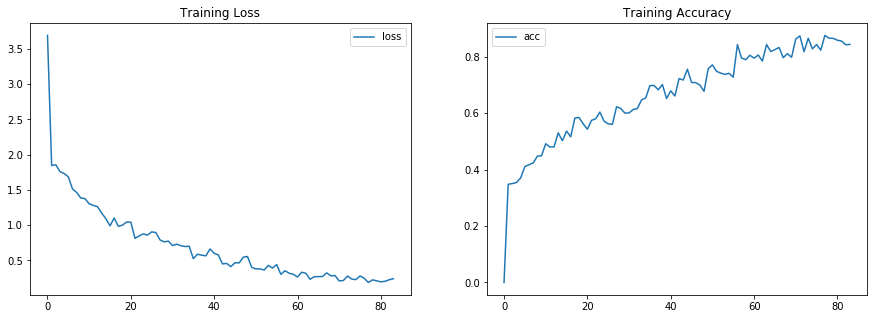

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

## Make predictions


To restore the lastest checkpoint, saved model, you can run the following cell:

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In the prediction step, our input is a secuence of length one, the sos token, then we call the encoder and decoder repeatedly until we get the eos token or reach the maximum length defined.

In [41]:
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))


It is time to show how our model works with some simple examples: 

In [46]:
test_sents = [input_data[10003], input_data[10120]]
#test_sents = [encoder_inputs[1000]]
print(test_sents)
for test_sent in test_sents:
    predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

['we re not going .', 'why are you sad ?']
[[ 17  24  33 111   1   0   0   0   0   0]]
no vamos . <eos>
[[ 69  22   3 326   5   0   0   0   0   0]]
¿ por que estas triste ? <eos>


## The Attention Mechanism

The previously described model based on RNNs has a serious problem when working with long sequences, because the information of the first tokens is lost or diluted as more tokens are processed. The context vector has been given the responsibility of encoding all the information in a given source sentence in to a vector of few hundred elements. it made it challenging for the models to deal with long sentences. A solution was proposed in Bahdanau et al., 2014 [4] and Luong et al., 2015,[5].


They introduce a technique called "Attention", which highly improved the quality of machine translation systems. Attention allows the model to focus on the relevant parts of the input sequence as needed, accessing to all the past hidden states of the encoder, instead of just the last one. At each decoding step, the decoder gets to look at any particular state of the encoder and can selectively pick out specific elements from that sequence to produce the output. We will focus on the Luong perspective.


### Loung Attention layer

![Alt](images/luong_attention.PNG "Attention Mechanism by Gabriel Loye [6]")

There are two relevant points to focus on:

- The **alignment vector**: is a vector with the same length that the input or source sequence and is computed at every time step of the decoder. Each of its values is the score (or the probability) of the corresponding word within the source sequence, they tell the decoder what to focus on at each time step. 

    There are three ways to calculate the alingment scores:

    - *Dot product*: we only need to take the hidden states of the encoder and multiply them by the hidden state of the decoder
    - *General*: very similar to dot product but a weight matrix is included.
    - *Concat*: the decoder hidden state and encoder hidden states are added together first before being passed through a Linear layer with an tanh activation function and finally multiply by a weight matrix.
    
![Alt](images/formula_luong_attention.PNG "Decoder output")

The alignment scores are softmaxed so that the weights will be between 0 to 1.


- The context vector: It's the weighted average sum of the encoder's output, the dot product of the alignment vector and the encoder's output.


In [15]:
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment


### Decoder with Attention

Once our Attention Class has been defined, we can create the decoder. The complete sequence of steps when calling the decoder are:

- Generate the encoder hidden states as usual, one for every input token
- Apply a RNN to produce a new hidden state, taking its previous hidden state and the target output from the previous time step
- Calculate the alignment scores as described previously
- Calculate the context vector
- In the last operation, the context vector is concatenated with the decoder hidden state we generated previously, then it is passed through a linear layer which acts as a classifier for us to obtain the probability scores of the next predicted word

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_func):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(hidden_dim, attention_func)
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment


For testing purposes, we create a decoder and call it to check the output shapes:

In [17]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])

### Train step function

Now we can define our step train function, to train a batch data. It is very similar to the one we coded for the seq2seq model without attention but this time we pass all the hidden states returned by the encoder to the decoder. And we need to create a loop to iterate through the target sequences, calling the decoder for each one and calculating the loss function comparing the decoder output to the expected target.


In [139]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc


### Main train

In [140]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)


Epoch 1 Batch 0 Loss 3.0794 Acc:0.0000
Epoch 1 Batch 100 Loss 1.5153 Acc:0.4106
Epoch 1 Batch 200 Loss 1.3571 Acc:0.4490
Epoch 1 Batch 300 Loss 1.1166 Acc:0.5296
Time taken for 1 epoch 682.8766 sec

Epoch 2 Batch 0 Loss 1.1873 Acc:0.4848
Epoch 2 Batch 100 Loss 0.9923 Acc:0.5562
Epoch 2 Batch 200 Loss 1.0025 Acc:0.5470
Epoch 2 Batch 300 Loss 1.0277 Acc:0.5510
Time taken for 1 epoch 656.4251 sec

Epoch 3 Batch 0 Loss 0.8298 Acc:0.5680
Epoch 3 Batch 100 Loss 0.7965 Acc:0.6073
Epoch 3 Batch 200 Loss 0.8324 Acc:0.6023
Epoch 3 Batch 300 Loss 0.8243 Acc:0.6059
Time taken for 1 epoch 650.9733 sec

Epoch 4 Batch 0 Loss 0.6563 Acc:0.6423
Epoch 4 Batch 100 Loss 0.6277 Acc:0.6714
Epoch 4 Batch 200 Loss 0.6086 Acc:0.6497
Epoch 4 Batch 300 Loss 0.5977 Acc:0.6833
Time taken for 1 epoch 657.5127 sec

Epoch 5 Batch 0 Loss 0.4388 Acc:0.7050
Epoch 5 Batch 100 Loss 0.5328 Acc:0.6919
Epoch 5 Batch 200 Loss 0.5073 Acc:0.6619
Epoch 5 Batch 300 Loss 0.4655 Acc:0.6946
Time taken for 1 epoch 655.9225 sec

Epoch

### Evaluate the model

When training is done, we can plot the losses and accuracies obtained during training:

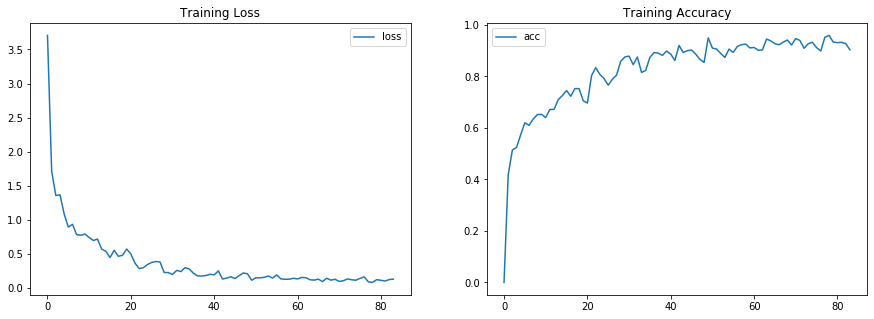

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

### Prediction or inference

We can restore the latest checkpoint of our model before making some predictions:

In [18]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    print(' '.join(out_words))
    return np.array(alignments), input_text.split(' '), out_words


It is time to test out model, making some predictions or doing some translation from english to spanish

she got him drunk .
ella le emborracho . <eos>


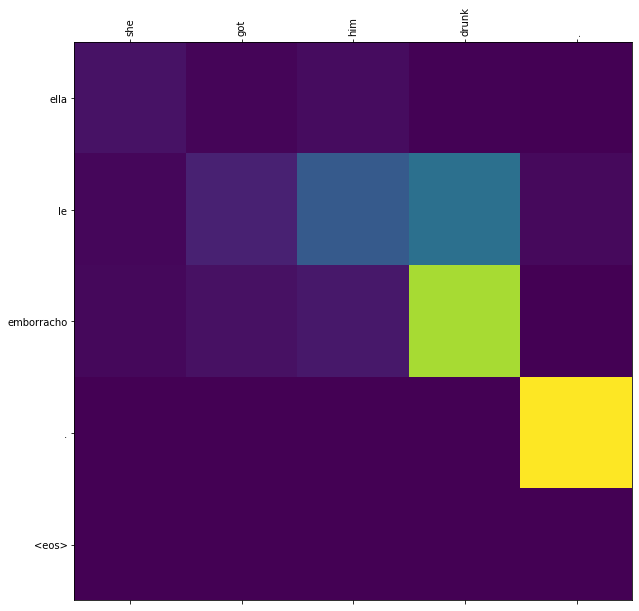

In [23]:
n_predictions=1
test_sents = input_data[15005:(15005+n_predictions)]

# Create the figure to plot in
fig = plt.figure(figsize=(10, 20))
for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                     word2idx_outputs, idx2word_outputs)
    attention = np.squeeze(alignments, (1, 2))
    # Create a subplot
    ax = fig.add_subplot(1, n_predictions, i+1)
    ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
    ax.set_xticklabels([''] + source, rotation=90)
    ax.set_yticklabels([''] + prediction)

plt.show()